In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#import tensorflow models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

#activate memory grows on tensorflow to avoid gpu errors
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

#check if gpu is available
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Available: ', len(physical_devices))

#print python version
import sys
sys.version

Num GPUs Available:  1


'3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]'

### Create a graph that shows the progress with matplotlib and with Tensorboard

In [2]:
from tensorflow.keras.callbacks import Callback, TensorBoard
from time import time
import matplotlib
# matplotlib.use('agg')

class TrainingPlot(Callback):
    def __init__(self, filename='training_plot.jpg'):
        self.filename = filename
        # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            N = np.arange(0, len(self.losses))
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            # Make sure there exists a folder called output in the current directory
            # or replace 'output' with whatever direcory you want to put in the plots
            plt.savefig(self.filename)
            plt.show()
            plt.close()

### Import images from folder to TF batched matrix + plot some example images

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


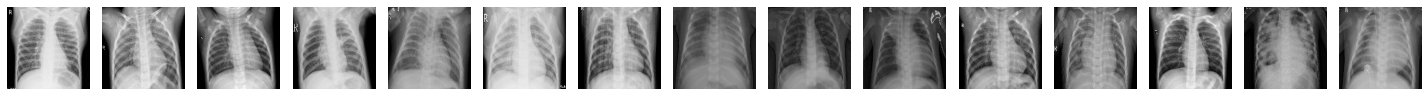

In [3]:
imgsize=150
batchSize = 32
train_batches = ImageDataGenerator().flow_from_directory(directory='train', target_size=(imgsize,imgsize),class_mode='binary',batch_size=batchSize) 
val_batches = ImageDataGenerator().flow_from_directory(directory='val', target_size=(imgsize,imgsize),class_mode='binary',batch_size=16)
test_batches = ImageDataGenerator().flow_from_directory(directory='test', target_size=(imgsize,imgsize),class_mode='binary',batch_size=batchSize)
#plot images
imgs, labels = next(train_batches)
def plotImages(images_arr):
    fig, axes = plt.subplots(1,15, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img.astype('uint8'))
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(imgs)

### create and compile the convolutional neural network

In [4]:
nn = Sequential()
# input shape = image shape + 3 colors on 3rd dimension
nn.add(Conv2D(32,3,padding='same', activation='relu',input_shape=(imgsize,imgsize,3)))
nn.add(MaxPool2D())
nn.add(Dropout(0.2))
nn.add(Conv2D(64, 3, padding='same',activation='relu'))
nn.add(MaxPool2D())
nn.add(Dropout(0.2))
nn.add(Conv2D(128, 3, padding='same',activation='relu'))
nn.add(MaxPool2D())
nn.add(Dropout(0.2))
nn.add(Conv2D(256, 3, padding='same',activation='relu'))
nn.add(MaxPool2D())
nn.add(Dropout(0.2))
nn.add(Flatten())
nn.add(Dense(128,activation='relu'))
nn.add(Dense(1,activation='sigmoid'))
nn.summary()
nn.compile(optimizer='rmsprop', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       7

In [5]:
plotLoss = TrainingPlot()
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
fitResult=nn.fit(train_batches, 
                 validation_data=val_batches, 
                 batch_size=batchSize, validation_batch_size=16,
                 epochs=3,
                 callbacks=[tensorboard])
evalResult=nn.evaluate(test_batches, batch_size=batchSize)
print("Loss of the model is - " , evalResult[0])
print("Accuracy of the model is - " , evalResult[1]*100 , "%")

Epoch 1/3
  1/163 [..............................] - ETA: 0s - loss: 16.9191 - accuracy: 0.6875WARNING:tensorflow:From C:\Users\konst\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
163/163 [==============================] - 71s 436ms/step - loss: 56.4137 - accuracy: 0.7441 - val_loss: 0.6666 - val_accuracy: 0.5625
Epoch 2/3
163/163 [==============================] - 49s 303ms/step - loss: 0.4287 - accuracy: 0.8610 - val_loss: 0.3768 - val_accuracy: 0.8125
Epoch 3/3
20/20 [==============================] - 8s 400ms/step - loss: 1.1302 - accuracy: 0.7676
Loss of the model is -  1.1301708221435547
Accuracy of the model is -  76.76281929016113 %


#### Get YTrue labels by merging TF batches and extracting [1] argument + merge with ytrue label to create the confusionmatrix

<AxesSubplot:>

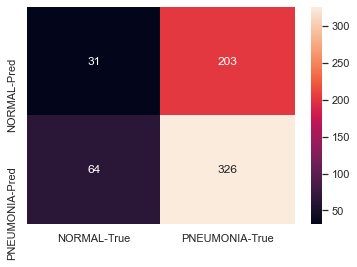

In [6]:
ypred = np.concatenate(np.uint(np.round(nn.predict(test_batches))))
ytrue = np.uint(np.concatenate([test_batches[i][1] for i in range(0, len(test_batches))]))
confusionmatrix = confusion_matrix(ytrue, ypred)
sns.heatmap(confusionmatrix, annot=True, fmt="d", xticklabels=['NORMAL-True', 'PNEUMONIA-True'], yticklabels=['NORMAL-Pred', 'PNEUMONIA-Pred'])